In [1]:
#Foldername that contains data
FolderName = '/Users/seetha//Desktop/Nd2filesforscalebars/Data/Figure4-lateralviewAF4_exampledatafor scripts/Fish1351/'

#Other Stimulus parameters
light_type = ['Blue']
time_end = 4000
frames_per_sec = 13

#Region to analyze
region_to_analyze = 'AF4'
stimulus_to_analyze = 'Blue'

#True to create new dataset, False to use previously saved dataset
savemode_loaddata = False
savemode_background = True
savemode_detrenddata = True
savemode_zscoredata = True
savemode_smootheddata = True

## Algorithm

### Start Thunder
Check http://thunder-project.org/thunder/docs/tutorials.html for more details and on instructions to run it on EC2

In [2]:
# Create new config - To avoid maxResultSize error. Stop Spark context and reload ThunderContext
from thunder import ThunderContext
from pyspark import SparkConf, SparkContext

conf = (SparkConf()
    .set("spark.driver.maxResultSize", "0"))

sc.stop()
# Create new thunder context using the configuration
print 'Starting Thunder Now. Check console for details'
tsc = ThunderContext.start(appName="thunderpca", conf=conf)

# Start Thunder and get thunder constant
# print 'Starting Thunder Now. Check console for details'
# from thunder import ThunderContext
# tsc = ThunderContext.start(appName="thunderpca")

Starting Thunder Now. Check console for details


### 1. Import libraries

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from thunder import Colorize
import os
import sys
from copy import copy
from matplotlib.colors import ListedColormap
from matplotlib.backends.backend_pdf import PdfPages

/Users/seetha/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
filesep = os.path.sep
%matplotlib inline
sns.set_context('notebook', font_scale=1.5)

#### Generate Stimulus on and Off times
Example Data Parameters are : 7 pulses of blue light, 20 seconds each with an ITI of 20 seconds. 

Correct arguments given for this experiment type
number of stimulus pulses caluculated is 7
For this experiment:
 Stimulus ON at : [244, 764, 1284, 1804, 2324, 2844, 3364]
 Stimulus OFF at : [504, 1024, 1544, 2064, 2584, 3104, 3624]
 Type of Stimulus is : ['Blue', 'Blue', 'Blue', 'Blue', 'Blue', 'Blue', 'Blue']
 Colormap for PCA is:


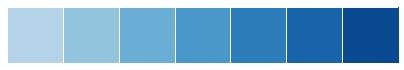

In [5]:
import generate_stim_on_and_off_times
reload(generate_stim_on_and_off_times)
from generate_stim_on_and_off_times import GetStimulusOnOffTimes
stimulus_on_time, stimulus_off_time, stimulus_train, color_mat = \
GetStimulusOnOffTimes('HighSpeed13fps', light_type=light_type, time_end = time_end, frames_per_sec=frames_per_sec)\
.get_stimulus_parameters()

In [6]:
#Create directory for Figures
Figure_PDFDirectory = os.path.join(FolderName, region_to_analyze, stimulus_to_analyze, 'Figures') + filesep
if not os.path.exists(Figure_PDFDirectory):
    os.makedirs(Figure_PDFDirectory)
FishName =  os.path.basename(os.path.normpath(FolderName)) #Get fishname to append to Figures

In [7]:
#Create directories to store Series Dataset
SeriesDirectory = os.path.join(FolderName, region_to_analyze, stimulus_to_analyze, 'SeriesDatasets') + filesep
if not os.path.exists(SeriesDirectory):
    os.makedirs(SeriesDirectory)

In [8]:
#Create directories to store result npz
NpzDirectory = os.path.join(FolderName, region_to_analyze, stimulus_to_analyze, 'NumpyArrays') + filesep
if not os.path.exists(NpzDirectory):
    os.makedirs(NpzDirectory)

### 2.Preprocess data

In [37]:
#Load functions for preprocessing first
import functions_for_preprocessing
reload(functions_for_preprocessing)
from functions_for_preprocessing import class_preprocess_data
analyze = class_preprocess_data(tsc, stimulus_on_time, stimulus_off_time, stimulus_train, SeriesDirectory)

In [10]:
filename = os.path.join(FolderName, region_to_analyze, stimulus_to_analyze, '16bit') + filesep
print filename
#Raise error if no such folder exists
if not(os.path.isdir(filename)):
    raise(ValueError('There are no such folders'))

/Users/seetha//Desktop/Nd2filesforscalebars/Data/Figure4-lateralviewAF4_exampledatafor scripts/Fish1351/AF4/Blue/16bit/


In [11]:
# Crop Image
crop = 1 
img_size_crop_y1 = 5  # How many pixels to crop on x and y axis. If none say 0
img_size_crop_y2 = 5
img_size_crop_x1 = 5  
img_size_crop_x2 = 5

# Registration
register = 0

In [12]:
!free -m

/bin/sh: free: command not found


In [13]:
# LOad data  
pp = PdfPages(Figure_PDFDirectory + FishName+'_Preprocessed_Data.pdf')
if savemode_loaddata:    
    analyze.load_and_preprocess_data(filename, crop, register, img_size_crop_x1, img_size_crop_x2, img_size_crop_y1,
                                 img_size_crop_y2, medianfilter_window=2, start_frame=0, end_frame=time_end, pdffile=pp)
    if register: #Load data as series to speed up analysis
        data = analyze.loadseriesdataset('registered_data')
    else:
        data = analyze.loadseriesdataset('raw_data')
else:     
    if register:
        data = analyze.loadseriesdataset('registered_data')
    else:
        data = analyze.loadseriesdataset('raw_data')

Loading pre saved series dataset


In [14]:
img_raw = data.seriesMean().pack() #Raw image also used as background image for plotting spatial maps
examples = analyze.get_small_subset_for_plotting(data, number_samples=100, threshold=50) #Subset of traces to plot. 

In [15]:
time_experiment = time_end
print 'Time points in experiment..', time_experiment

Time points in experiment.. 4000


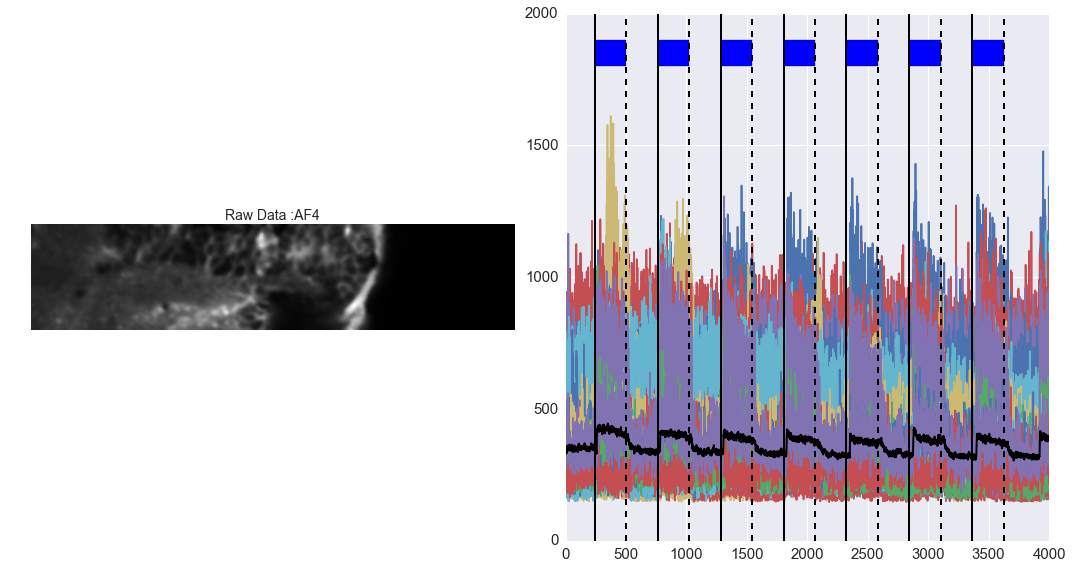

In [16]:
# Plot mean and traces of raw data
fig1 = plt.figure(figsize=(15,8))
gs = plt.GridSpec(1, 2)
title = 'Raw Data :'
analyze.plotimageplanes(fig1, gs, img_raw, plot_title= title + region_to_analyze, gridspecs='[0, 0]')
analyze.plot_traces(fig1, gs, examples, gridspecs='[0, 1]')
plt.tight_layout()
plt.show()
pp.savefig(fig1, bbox_inches='tight')
pp.close()

In [17]:
!free -m

/bin/sh: free: command not found


## Subtract Background

Saving as series dataset frombgubtracted_data


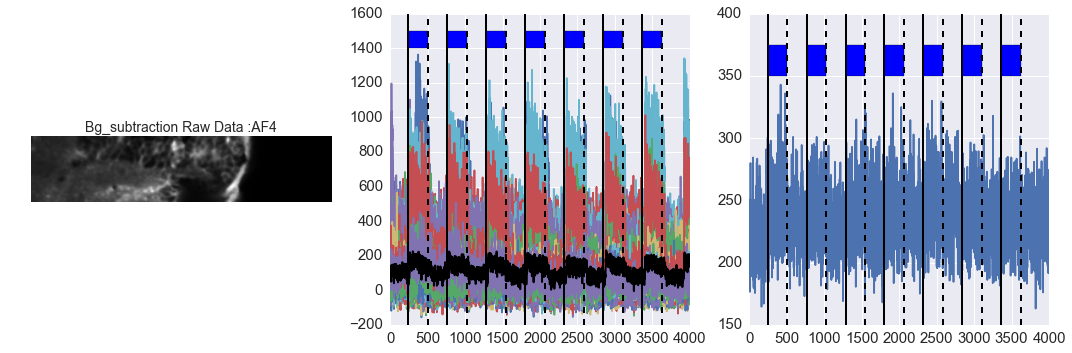

In [38]:
background_subtraction_flag = 1
if background_subtraction_flag:
    if savemode_background:

        subtracted_data, bg_trace = analyze.background_subtraction(data)

        examples = analyze.get_small_subset_for_plotting(subtracted_data, number_samples=100, threshold=50)
        img_bgsub = subtracted_data.seriesMean().pack()

        pp = PdfPages(Figure_PDFDirectory + FishName+'_BackgroundSubtracted.pdf')
        fig1 = plt.figure(figsize=(15,5))
        gs = plt.GridSpec(1, 3)
        analyze.plotimageplanes(fig1, gs, img_raw, plot_title= 'Bg_subtraction ' + title + region_to_analyze, gridspecs='[0, 0]')
        analyze.plot_traces(fig1, gs, examples, gridspecs='[0, 1]')
        analyze.plot_traces(fig1, gs, bg_trace.first()[1], gridspecs='[0, 2]')
        plt.tight_layout()
        plt.show()
        pp.savefig(fig1, bbox_inches='tight')
        pp.close()

    else:
        subtracted_data = analyze.loadseriesdataset('bgubtracted_data')

## Non-linear detrend of data

In [39]:
if savemode_detrenddata and background_subtraction_flag==0: 
    data_detrend = analyze.detrend_data(data, detrend_order=10)
elif savemode_detrenddata and background_subtraction_flag==1:
    data_detrend = analyze.detrend_data(subtracted_data, detrend_order=5)
else:    
    data_detrend = analyze.loadseriesdataset('detrended_data')

Saving as series dataset fromdetrended_data


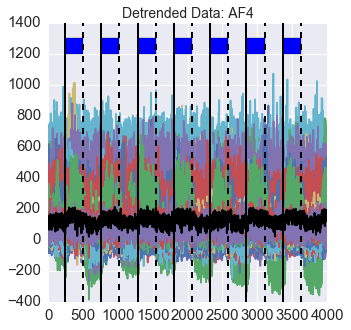

In [40]:
# Plot figures
pp = PdfPages(Figure_PDFDirectory + FishName +'_DetrendedData.pdf')
examples = analyze.get_small_subset_for_plotting(data_detrend, number_samples=100, threshold=50)
    
#Plot
fig1 = plt.figure(figsize=(5, 5))
gs = plt.GridSpec(1,1)
analyze.plot_traces(fig1, gs, examples, \
                        plot_title='Detrended Data: ' + region_to_analyze)
pp.close()

In [41]:
!free -m

/bin/sh: free: command not found


### 3. Normalize data

In [125]:
if savemode_zscoredata:   
    zscore = analyze.normalize(data_detrend, squelch_parameter=150)
else:
    zscore = analyze.loadseriesdataset('zscore_data')

Saving as series dataset fromzscore_data


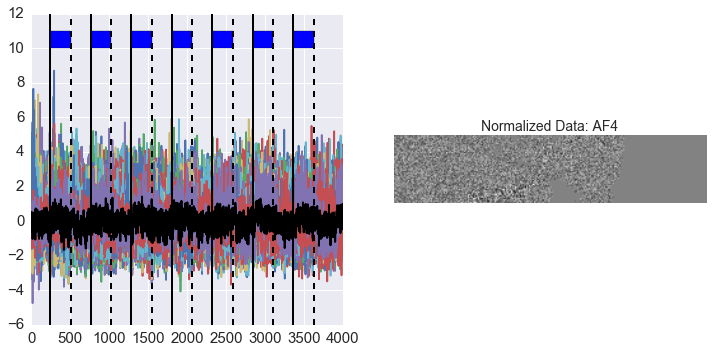

In [126]:
#Plot figures
pp = PdfPages(Figure_PDFDirectory + FishName +'_Normalized.pdf')

examples = analyze.get_small_subset_for_plotting(zscore, number_samples=100, threshold=0.1)
img = zscore.seriesMean().pack()

fig1 = plt.figure(figsize=(10,5))
gs = plt.GridSpec(1,2)
analyze.plotimageplanes(fig1, gs, img,  plot_title='Normalized Data: '+region_to_analyze, gridspecs='[0, 1]')
analyze.plot_traces(fig1, gs, examples, gridspecs='[0,0]')
plt.tight_layout()
plt.show()
pp.savefig(fig1, bbox_inches='tight')
pp.close()

In [127]:
!free -m

/bin/sh: free: command not found


## Smooth Data

In [128]:
windowlen = 35
if savemode_smootheddata:    
    zscore_smooth = zscore.toTimeSeries().smooth(window_len=windowlen) 
    analyze.saveasseries(data=zscore_smooth, savefilename='smoothed_data')
else:
    zscore_smooth = analyze.loadseriesdataset('smoothed_data')

Saving as series dataset fromsmoothed_data


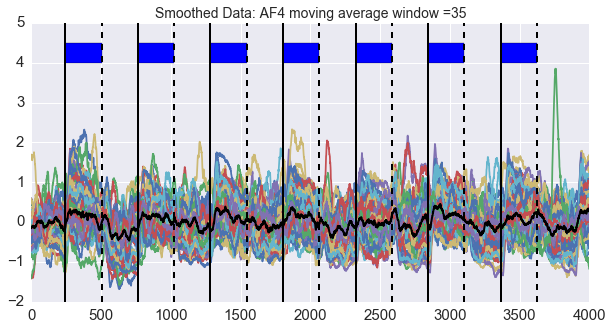

In [129]:
pp = PdfPages(Figure_PDFDirectory + FishName +'Smoothed.pdf')
examples = analyze.get_small_subset_for_plotting(zscore_smooth, number_samples=100, threshold=0.05)  
    
fig1 = plt.figure(figsize=(10,5))
gs  = plt.GridSpec(1,1)
analyze.plot_traces(fig1, gs, examples, num_subplots=1, \
                   plot_title='Smoothed Data: ' + region_to_analyze + \
                    ' moving average window =' + str(windowlen))
plt.show()
pp.savefig(fig1)
pp.close()

In [27]:
!free -m

/bin/sh: free: command not found


## PCA

In [150]:
PCA_data = zscore_smooth

In [151]:
# PCA parameters 
pca_components_ind = 4  # Number of pca components to detect from files
num_pca_colors = 50  # Number of colors on the pca maps
num_samples = 10000  # number of random samples to select to do PCA reconstruction
thresh_pca = 0.0001  # Threshold above which to plot the pca components
color_map = "polar"

In [152]:
#Load functions for PCA
import functions_for_PCA
reload(functions_for_PCA)
from functions_for_PCA import class_PCA
PCA = class_PCA(pca_components_ind, PCA_data, img_raw, num_pca_colors, num_samples,\
                    thresh_pca, color_map, color_mat,stimulus_on_time, stimulus_off_time, stimulus_train)

In [179]:
#Run PCA
required_pcs = [0, 1, 2]

In [173]:
model_PCA = PCA.run_pca()

In [180]:
imgs = PCA.get_pca_scores(model_PCA, required_pcs)

In [181]:
maps, pts, clrs, recon, unique_clrs_PCA, matched_pixels_PCA, \
               matched_signals, mean_signal, sem_signal = PCA.make_pca_maps(model_PCA, imgs, \
                                                       required_pcs, mixing_parameter=0.5)

In [182]:
pca_components = model_PCA.comps.T
pca_eigenvalues = model_PCA.latent

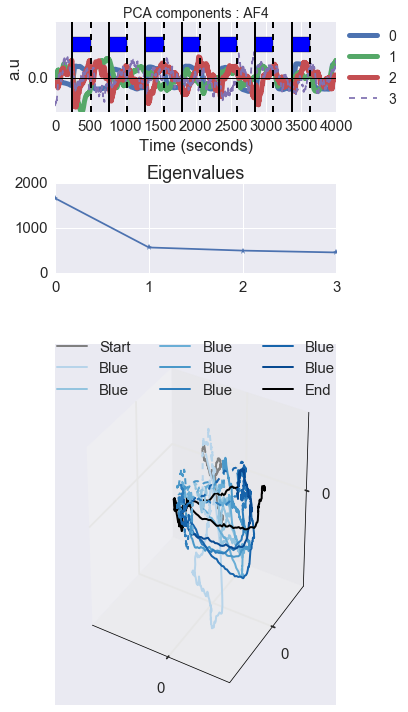

In [186]:
pp = PdfPages(Figure_PDFDirectory + FishName + '_PCA.pdf')

fig1 = plt.figure(figsize=(10,10))

gs = plt.GridSpec(3,5, height_ratios=[0.25,0.25,1], width_ratios=[0.5,1.5,0.25,0.5,1.5])
PCA.plot_pca_components(fig1, gs, pca_components, required_pcs, plot_title='PCA components : ' + region_to_analyze, gridspecs='[0,0:2]')

PCA.plot_eigenvalues(fig1, gs, pca_eigenvalues, gridspecs='[1, 0:2]')

if len(required_pcs) == 3:
    PCA.plot_stimulus_in_3d(fig1, gs, pca_components, required_pcs, 'z', gridspecs='[2,0:2]')
else:
    PCA.plot_stimulus_in_2d(fig1, gs, pca_components, required_pcs, gridspecs='[2,0:2]')

plt.tight_layout()
plt.show()
pp.savefig(fig1, bbox_inches='tight')

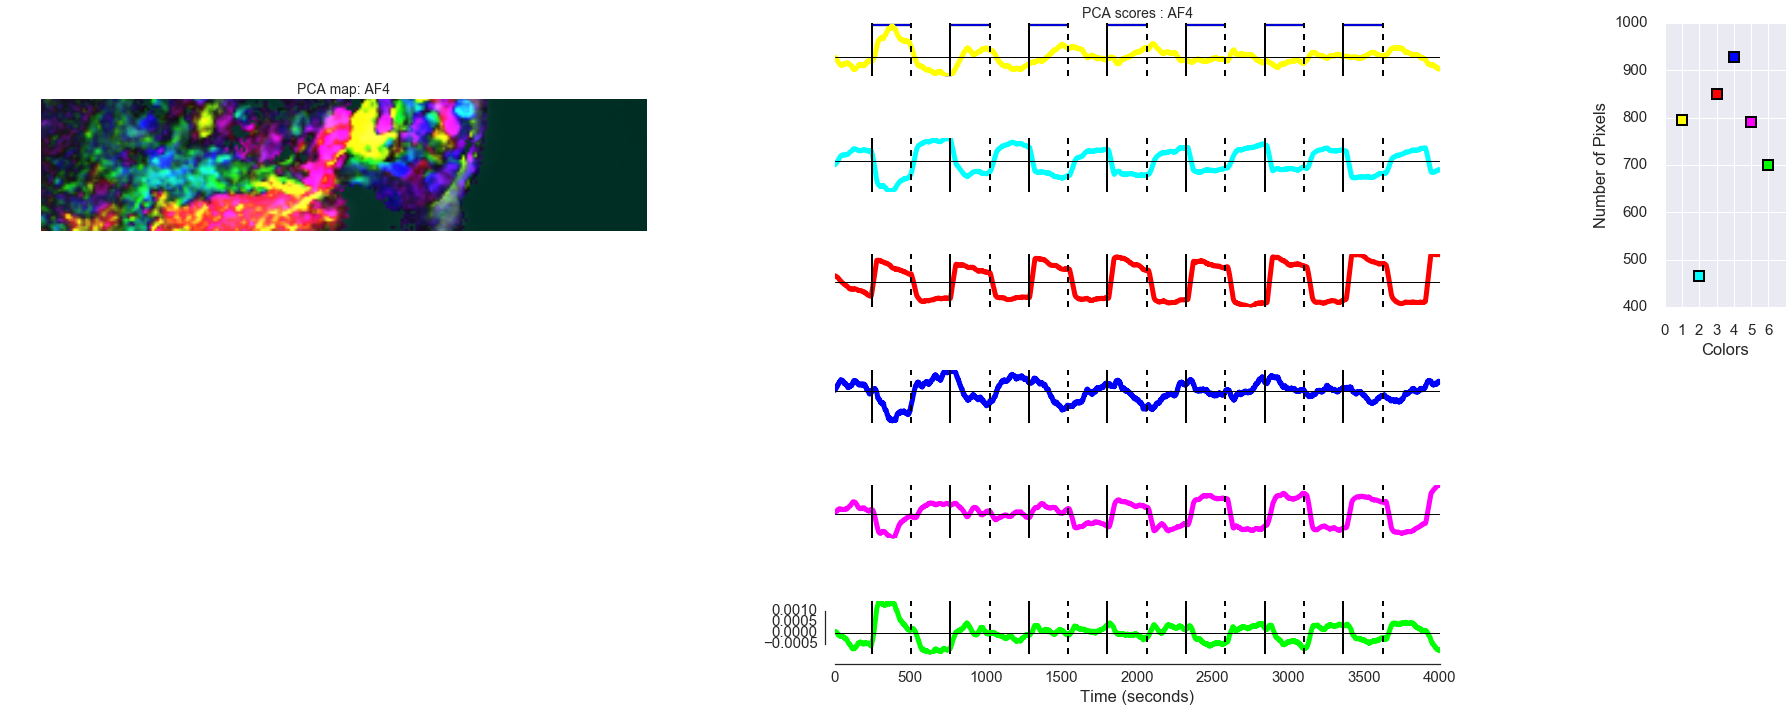

In [187]:
fig1 = plt.figure(figsize=(25,10))
gs = plt.GridSpec(6,5, width_ratios=[5,0.2,5,0.5,1])
PCA.plotimageplanes(fig1, gs, maps , plot_title='PCA map: ' + region_to_analyze,\
                        gridspecs='[0:3,0]')

PCA.plot_scores_individually(fig1, gs, mean_signal, sem_signal, unique_clrs_PCA, plot_title='PCA scores : ' + region_to_analyze, gridspecs='[0, 2]')

PCA.plot_matchedpixels(fig1, gs, matched_pixels_PCA, unique_clrs_PCA, gridspecs='[0:3,4]')

plt.tight_layout()
plt.show()
pp.savefig(fig1, bbox_inches='tight')

pp.close()

In [188]:
np.savez(NpzDirectory + 'pca_results.npz', pca_components=pca_components,
                 pca_eigenvalues=pca_eigenvalues, new_imgs=imgs, maps=maps, pts=pts, clrs=clrs,
                 recon=recon, unique_clrs=unique_clrs_PCA, matched_pixels=matched_pixels_PCA, matched_signals=matched_signals,
                 mean_signal=mean_signal, sem_signal=sem_signal, required_pcs=required_pcs)

## Run Kmeans

In [130]:
#Kmeans_Parameters
kmeans_clusters_num = 8
kmeans_data = zscore_smooth

In [131]:
#Load functions for kmeans 
import functions_for_kmeans
reload(functions_for_kmeans)
from functions_for_kmeans import class_kmeans
kmeans = class_kmeans(kmeans_clusters_num, kmeans_data, img_raw, stimulus_on_time, stimulus_off_time, stimulus_train)

In [132]:
# Perform kmeans
model_kmeans, img_sim, img_labels = kmeans.run_kmeans()

In [133]:
kmeans_clusters = model_kmeans.centers.T

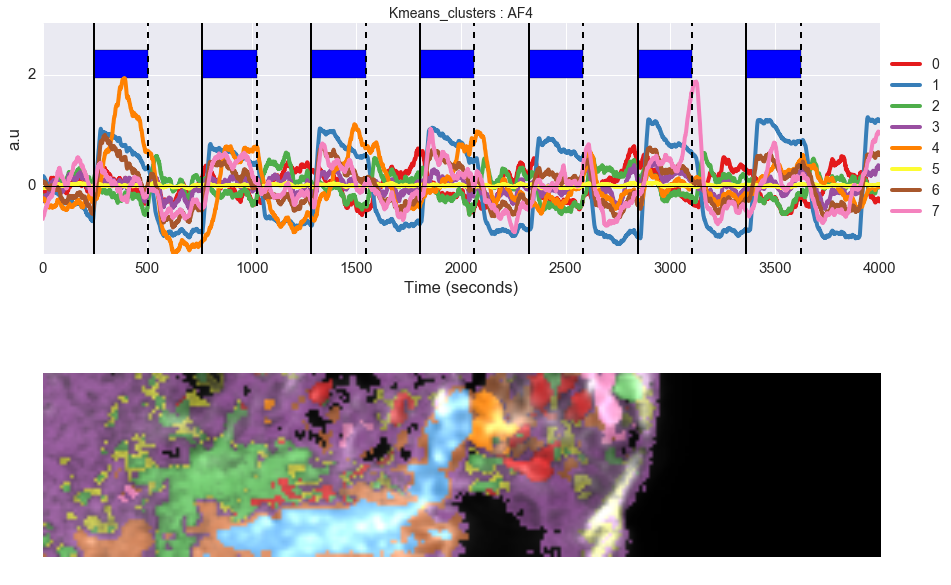

In [134]:
### Check plots with a random colormap
fig1 = plt.figure(figsize=(15,10))
gs = plt.GridSpec(7, 7)
cmapCat = ListedColormap(sns.color_palette("Set1", n_colors=kmeans_clusters_num), name='from_list')
centered_cmap = kmeans.plot_kmeans_components(fig1, gs, kmeans_clusters[:,:], cmapCat,
                                  plot_title='Kmeans_clusters : ' + region_to_analyze, 
                                  gridspecs='[0:3,0:]', model_center=0)
kmeans.createbrainmap_withcmap(fig1,gs, centered_cmap, img_labels, img_sim, mixing_parameter = 1, gridspecs='[4:,0:]')

plt.show()

In [137]:
#Use a colorbrewer colormap to create map of brain
ignore_clusters = [0,4, 3, 5, 7]
brainmap, unique_clrs, newclrs_updated_rgb, newclrs_updated_brewer, matched_pixels, \
kmeans_clusters_updated = kmeans.make_kmeans_maps(kmeans_clusters, \
                                                          img_labels, img_sim, mixing_parameter=1,
                                                          std_threshold=0.01, ignore_clusters=ignore_clusters)

Standard deviation of clusters is.. [ 0.26284199  0.73719915  0.23717794  0.16030192  0.53188721  0.01971846
  0.35984776  0.42678744]
Interesting clusters after STD are.. [[0 1 2 3 4 5 6 7]]
Interesting clusters after user specified clusters.. [1 2 6]


0
4
3
5
7


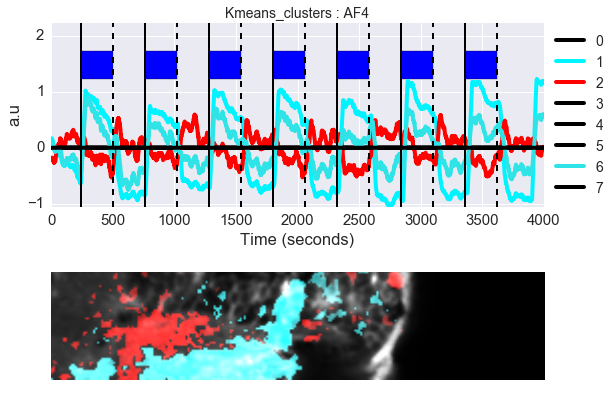

In [146]:
pp = PdfPages(Figure_PDFDirectory + FishName + '_KMeans2.pdf')
fig1 = plt.figure(figsize=(8,6))
gs = plt.GridSpec(4, 2)
cmapCat = ListedColormap(sns.color_palette("Paired", n_colors=kmeans_clusters_num), name='from_list')
centered_cmap = kmeans.plot_kmeans_components(fig1, gs, kmeans_clusters[:,:], cmapCat,\
                                  plot_title='Kmeans_clusters : ' + region_to_analyze,
                                  gridspecs='[0:2,0:]', model_center=1,\
                                              removeclusters = ignore_clusters)

kmeans.createbrainmap_withcmap(fig1,gs, centered_cmap, img_labels, img_sim, mixing_parameter = 1.2, gridspecs='[2:,0:]')

plt.tight_layout()
pp.savefig(fig1, bbox_inches='tight')

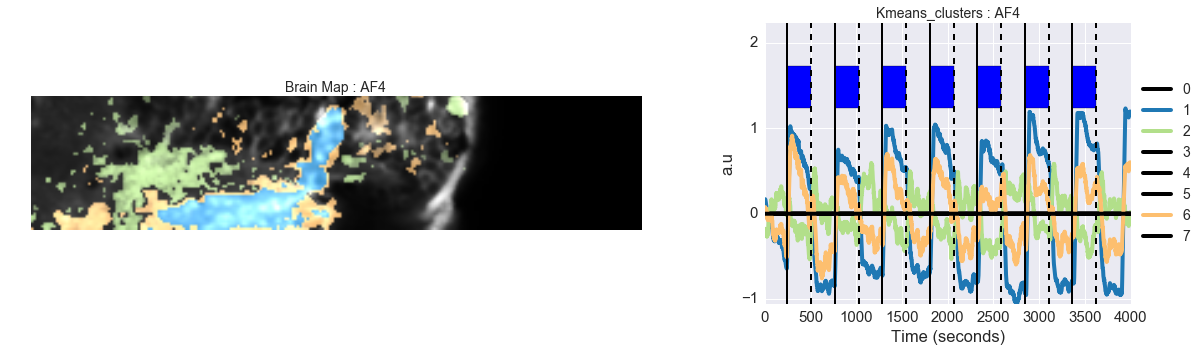

In [147]:
fig1 = plt.figure(figsize=(20,5))
gs = plt.GridSpec(1,5,width_ratios=[5,0.1,3,0.5,1])
kmeans.plotimageplanes(fig1, gs, brainmap , plot_title='Brain Map : '+region_to_analyze, gridspecs='[0,0]')
kmeans.plot_kmeans_components(fig1, gs, kmeans_clusters_updated, newclrs_updated_brewer,\
                              plot_title='Kmeans_clusters : ' + region_to_analyze, gridspecs='[0,2]', model_center=0)

plt.tight_layout()
plt.show()
pp.savefig(fig1, bbox_inches='tight')


In [148]:
pp.close()

In [149]:
np.savez(NpzDirectory + 'kmeans_results.npz', kmeans_clusters=kmeans_clusters, ignore_clusters=ignore_clusters, 
         kmeans_clusters_updated=kmeans_clusters_updated, img_labels = img_labels, img_sim = img_sim, 
         brainmap = brainmap, unique_clrs = unique_clrs, newclrs_updated_rgb = newclrs_updated_rgb, 
         newclrs_updated_brewer = newclrs_updated_brewer, matched_pixels = matched_pixels, centered_cmap = centered_cmap.colors, reference_image=img_raw)